# Transfer Learning

In [1]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np



In [2]:
EPOCHS = 5
Batch_size = 32

train_loc = "ey-dataset/train"
test_loc = "ey-dataset/test"
val_loc = "ey-dataset/val"

# Data Agumention

In [3]:
# train data
trdata = ImageDataGenerator(rescale=1./255, 
                            shear_range=0.2,
                            zoom_range=0.2, 
                            horizontal_flip=True, 
                            fill_mode="nearest")
traindata = trdata.flow_from_directory(directory=train_loc, 
                                       target_size=(196,196), 
                                       shuffle=True)

# test Data
tsdata = ImageDataGenerator(rescale=1./255)
testdata = tsdata.flow_from_directory(directory=test_loc, 
                                      target_size=(196,196), 
                                      shuffle=False)

# val data
vdata = ImageDataGenerator(rescale=1./255)
valdata = vdata.flow_from_directory(directory=val_loc, 
                                    target_size=(196,196), 
                                    shuffle=True)

traindata.class_indices

Found 33456 images belonging to 2 classes.
Found 4182 images belonging to 2 classes.
Found 4182 images belonging to 2 classes.


{'CT_COVID': 0, 'CT_NonCOVID': 1}

# Model Architecture

In [4]:
input_shape = (196,196, 3)
img_input = Input(shape=input_shape, name='ey-image-input')

# Build the model
x = Conv2D(32, (3, 3), padding='same',activation='relu', name='ey-layer_1')(img_input)
x = Conv2D(64, (3, 3), padding='same', activation='relu', name='ey-layer_2')(x)
x = MaxPool2D((2, 2), strides=(2, 2), name='ey-layer_3')(x)
x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu', name='ey-layer_4')(x)
x = MaxPool2D((2, 2), strides=(2, 2), name='et-layer_5')(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu', name='ey-layer_6')(x)
x = MaxPool2D((2, 2), strides=(2, 2), name='ey-layer_7')(x)
x = Dropout(0.25)(x)

x = Flatten(name='ey-layer_8')(x)
x = Dense(64, name='ey-layer_9')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax', name='predections')(x)

# generate the model
model = Model(inputs=img_input, outputs=x, name='ey-cnn')

# print network structure
model.summary()

Metal device set to: Apple M1 Pro
Model: "ey-cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ey-image-input (InputLayer)  [(None, 196, 196, 3)]    0         
                                                                 
 ey-layer_1 (Conv2D)         (None, 196, 196, 32)      896       
                                                                 
 ey-layer_2 (Conv2D)         (None, 196, 196, 64)      18496     
                                                                 
 ey-layer_3 (MaxPooling2D)   (None, 98, 98, 64)        0         
                                                                 
 dropout (Dropout)           (None, 98, 98, 64)        0         
                                                                 
 ey-layer_4 (Conv2D)         (None, 98, 98, 64)        36928     
                                                                 
 et-layer_5 (MaxPooling2D)

2023-04-01 21:54:40.417001: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-01 21:54:40.417127: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Compile  model

In [5]:
print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-4)

model.compile(loss="categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=2, verbose=1, 
                                                 mode="auto")]


[INFO] compiling model...


# train the head of the network

In [6]:
print("[INFO] training head...")
hist = model.fit(
    traindata, 
    batch_size=Batch_size,
    steps_per_epoch=traindata.samples // Batch_size,
    validation_steps=valdata.samples // Batch_size,
    callbacks=my_callbacks,
    epochs=EPOCHS,
    validation_data=valdata
)

[INFO] training head...
Epoch 1/5


2023-04-01 21:54:40.789911: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-01 21:54:41.066901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1045/1045 [==============================] - ETA: 0s - loss: 0.5556 - accuracy: 0.7061

2023-04-01 21:57:43.157199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1045/1045 [==============================] - 191s 182ms/step - loss: 0.5556 - accuracy: 0.7061 - val_loss: 0.4661 - val_accuracy: 0.7776
Epoch 2/5
1045/1045 [==============================] - 190s 181ms/step - loss: 0.3624 - accuracy: 0.8390 - val_loss: 0.3279 - val_accuracy: 0.8656
Epoch 3/5
1045/1045 [==============================] - 189s 181ms/step - loss: 0.2323 - accuracy: 0.9035 - val_loss: 0.1679 - val_accuracy: 0.9288
Epoch 4/5
1045/1045 [==============================] - 190s 182ms/step - loss: 0.1562 - accuracy: 0.9406 - val_loss: 0.1383 - val_accuracy: 0.9536
Epoch 5/5
1045/1045 [==============================] - 190s 181ms/step - loss: 0.1021 - accuracy: 0.9603 - val_loss: 0.0966 - val_accuracy: 0.9625


# accuracy & loss curves

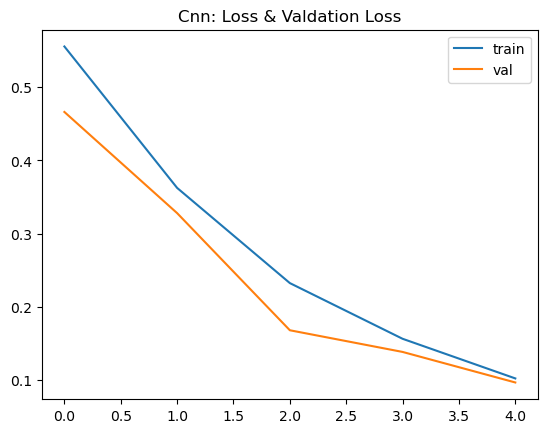

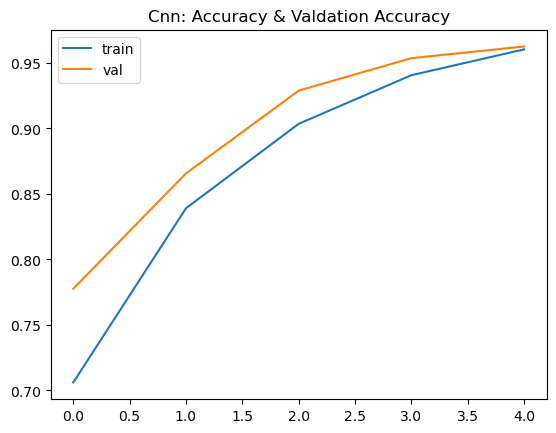

131/131 [==============================] - 8s 62ms/step


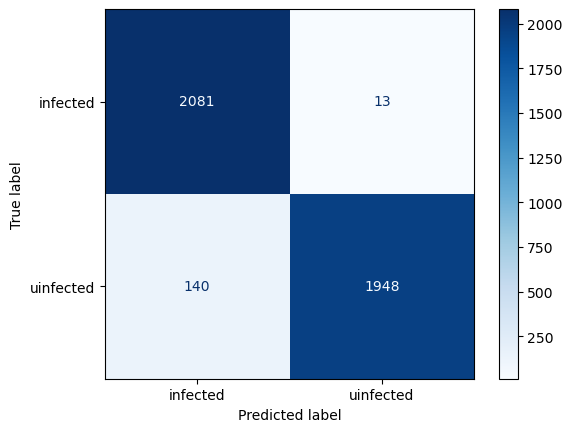

In [12]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('Cnn: Loss & Valdation Loss')
plt.legend()
plt.show()

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('Cnn: Accuracy & Valdation Accuracy')
plt.legend()
plt.show()

target_names = ["infected","uinfected"]
labels_names =[0,1]

Y_pred = model.predict(testdata)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(testdata.classes, y_pred, labels=labels_names)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues)

plt.show()

In [8]:
result = model.evaluate(testdata)

131/131 [==============================] - 9s 65ms/step - loss: 0.0932 - accuracy: 0.9634


In [9]:
model.save('./finalmodel.h5')